In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

In [2]:
def fix_seed(random_seed):
    """
    fix random seed
    """
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'CPU')

In [4]:
with open('data.pkl', 'rb') as f:
    vars = pickle.load(f)

In [5]:
train_data, val_data, test_data = vars

In [6]:
fix_seed(51)

In [7]:
cnn_hidden_layers = 5
k = 3 #kernel_size
dropout_p = 0.1
lr = 0.00002
batch = 32 #batch_size
num_epochs = 30

In [8]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx][0]
        image = torch.from_numpy(np.array(image)).unsqueeze(0).float()
        info = torch.tensor(self.data[idx][1:5], dtype = torch.float32)
#         label = torch.tensor(self.data[idx][5],dtype = torch.float32)
        label = torch.from_numpy(np.array(self.data[idx][5])).unsqueeze(0).float()
        
        return image, info, label

In [9]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(512 * 9 * 9, 500),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True)
        )

        self.fcn = nn.Sequential(
            nn.Linear(4, 500),
            nn.ReLU()
        )
    
#         self.fc = nn.Linear(1000, 1)
        self.fc = nn.Sequential(
                nn.Linear(1000, 512),
                nn.LeakyReLU(negative_slope = 0.1, inplace=True),
                nn.Dropout(0.1),
                nn.Linear(512, 512),
                nn.LeakyReLU(negative_slope = 0.1, inplace=True),
                nn.Dropout(dropout_p),
                nn.Linear(512, 1)
            )
    
    def forward(self, image, info):
        x1 = self.cnn(image)
        x2 = self.fcn(info)
        x = torch.cat((x1, x2), dim = 1)
        x = torch.sigmoid(self.fc(x))
        return x

In [10]:
model = MyModel()
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)
print(model)

MyModel(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.1, inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.1, 

In [11]:
train_loader = DataLoader(MyDataset(train_data), batch_size = batch, shuffle = True)
val_loader = DataLoader(MyDataset(val_data), batch_size = batch, shuffle = False)

In [12]:
best_val_loss = float("Inf")
no_improve_epochs = 0
early_stop_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for _, (images, infos, labels) in enumerate(train_loader):
        images = images.to(device)
        infos = infos.float().to(device)
        labels = labels.float().to(device)
        
        outputs = model(images, infos)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss:{epoch_loss:.4f}')
    
    #validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, infos, labels in val_loader:
            images = images.to(device)
            infos = infos.float().to(device)
            labels = labels.float().to(device)
            outputs = model(images, infos)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        print(f'Validation Loss: {val_loss:4f}')
        
    #check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        no_improve_epochs += 1
        
    #early stopping
    if no_improve_epochs > early_stop_epochs:
        print('Early stopping...')
        break
    
        
    

Epoch [1/30], Loss:0.7140
Validation Loss: 0.644482
Epoch [2/30], Loss:0.6778
Validation Loss: 0.599497
Epoch [3/30], Loss:0.6061
Validation Loss: 0.556363
Epoch [4/30], Loss:0.5429
Validation Loss: 0.530604
Epoch [5/30], Loss:0.5298
Validation Loss: 0.525312
Epoch [6/30], Loss:0.5194
Validation Loss: 0.518455
Epoch [7/30], Loss:0.5113
Validation Loss: 0.543618
Epoch [8/30], Loss:0.5035
Validation Loss: 0.548299
Epoch [9/30], Loss:0.4988
Validation Loss: 0.507891
Epoch [10/30], Loss:0.4944
Validation Loss: 0.547370
Epoch [11/30], Loss:0.4823
Validation Loss: 0.507435
Epoch [12/30], Loss:0.4713
Validation Loss: 0.514210
Epoch [13/30], Loss:0.4758
Validation Loss: 0.518976
Epoch [14/30], Loss:0.4645
Validation Loss: 0.539262
Epoch [15/30], Loss:0.4601
Validation Loss: 0.503017
Epoch [16/30], Loss:0.4559
Validation Loss: 0.506815
Epoch [17/30], Loss:0.4486
Validation Loss: 0.498868
Epoch [18/30], Loss:0.4425
Validation Loss: 0.498074
Epoch [19/30], Loss:0.4382
Validation Loss: 0.495146
Ep

In [13]:
test_loader = DataLoader(MyDataset(test_data), batch_size = batch, shuffle = False)

model.eval()

predictions = []
probs_list = []
labels_list = []

correct = 0
total = 0


with torch.no_grad():
    for _, (images, infos, labels) in enumerate(test_loader):
        images = images.to(device)
        infos = infos.float().to(device)
        labels = labels.long().to(device)
        
        outputs = model(images, infos)
        
        preds = (outputs > 0.5).long()
        
        predictions.extend(preds.cpu().numpy())
        probs_list.extend(outputs.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (preds == labels).sum().item()

accuracy = 100 * correct / total
f1 = f1_score(labels_list, predictions, average = 'macro')
auc_score = roc_auc_score(labels_list, probs_list)

print('CNN hidden_layers: %d, kernel_size: %d, lr = %f, dropout_p: %.1f, batch_size: %d \n' %(cnn_hidden_layers, k, lr, dropout_p, batch))

print('Accuracy: %.2f %%' %accuracy)
print('F1 score: ', f1)
print('AUC:', auc_score)

CNN hidden_layers: 5, kernel_size: 3, lr = 0.000020, dropout_p: 0.1, batch_size: 32 

Accuracy: 73.38 %
F1 score:  0.7294777232251386
AUC: 0.8278793321733057


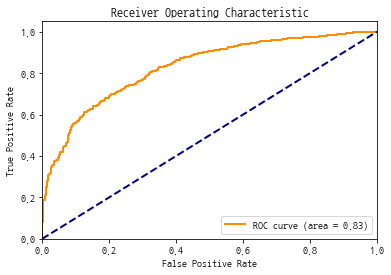

In [14]:
import sklearn.metrics as metrics
fpr, tpr, _ = roc_curve(labels_list, probs_list)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()